In [1]:
from IPython.display import display, Math, Latex
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

### Clusteranalyse in Python zum Milk-Datensatz
Wir analysieren Daten zur Zusammensetzung von Milch für 25 verschiedene Säugetiere.

In [2]:
path="/Users/julia/Desktop/Lehre/2025_WiSe/Multivariate_Analysemethoden/data"

In [3]:
# Load data
milk = pd.read_csv(path+"/milk.csv",sep=";", index_col=0)

#### 1 Überblick über den Datensatz und Standardisierung
Wir verschaffen uns zunächst einen Überblick über den Datensatz. Bevor wir die unterschiedlichen Clustering-Methoden durchführen, empfiehlt sich eine Standardisierung der Daten, falls die Skalen der Features sehr unterschiedlich sind (ist hier der Fall, z.B. $\texttt{water}$ vs. $\texttt{ash}$). Bei nicht-standardisierten Daten kann das Abstandsmaß (euklidische Distanz) durch Variablen mit höheren Skalen dominiert werden. Die Standardisierung garantiert, dass alle Features gleichermaßen zur Distanzberechnung im jeweiligen Cluster-Algorithmus beitragen.

In [4]:
# Zusammensetzung in Wasser, Protein, Fett, Laktose, Mineralien ("ash")
milk.head()

,name,water,protein,fat,lactose,ash
1,Horse,"90,1","2,6",1,"6,9","0,35"
2,Orangutan,"88,5","1,4","3,5",6,"0,24"
3,Monkey,"88,4","2,2","2,7","6,4","0,18"
4,Donkey,"90,3","1,7","1,4","6,2","0,4"
5,Hippo,"90,4","0,6","4,5","4,4","0,1"


In [5]:
# top = am häufigsten vorkommender Wert
# freq = Frequenz des am häufigsten vorkommenden Wertes
milk.describe()

,name,water,protein,fat,lactose,ash
count,25,25,25,25,25,25
unique,25,23,25,25,22,21
top,Horse,"64,8","2,6",1,"4,4","1,4"
freq,1,2,1,1,2,3


In [6]:
# Wir transformieren den dataframe, sodass wir nur numerische Werte in den Spalten haben
milk_measures = ["water", "protein", "fat", "lactose", "ash"]
milk_perc = milk[milk_measures]
milk_perc.index = milk['name']
milk_perc_numeric=milk_perc.copy()
for column in milk_perc.columns:
    milk_perc_numeric[column]=milk_perc[column].str.replace(',','.').astype(float)

In [7]:
milk_perc_numeric.head()

,water,protein,fat,lactose,ash
name,,,,,
Horse,90.1,2.6,1.0,6.9,0.35
Orangutan,88.5,1.4,3.5,6.0,0.24
Monkey,88.4,2.2,2.7,6.4,0.18
Donkey,90.3,1.7,1.4,6.2,0.40
Hippo,90.4,0.6,4.5,4.4,0.10


In [8]:
milk_perc_numeric.describe()

,water,protein,fat,lactose,ash
count,25.000000,25.000000,25.000000,25.00000,25.000000
mean,78.184000,6.212000,10.308000,4.13200,0.829200
std,12.817913,3.652547,10.517997,1.83183,0.473787
min,44.900000,0.600000,1.000000,0.00000,0.100000
25%,71.300000,3.000000,3.400000,2.70000,0.530000
50%,82.000000,5.900000,6.300000,4.70000,0.800000
75%,87.700000,9.700000,13.100000,5.60000,0.930000
max,90.400000,12.300000,42.000000,6.90000,2.300000


In [9]:
# Standardisierung der Daten, da Skalen sehr unterschiedlich (z.B. water vs ash)
scaler = StandardScaler()
milk_perc_numeric_stand = pd.DataFrame(scaler.fit_transform(milk_perc_numeric), columns=milk_measures, index=milk_perc.index)

In [10]:
milk_perc_numeric_stand.describe()

,water,protein,fat,lactose,ash
count,2.500000e+01,2.500000e+01,2.500000e+01,2.500000e+01,2.500000e+01
mean,-9.237056e-16,2.664535e-17,1.776357e-17,-2.575717e-16,-1.376677e-16
std,1.020621e+00,1.020621e+00,1.020621e+00,1.020621e+00,1.020621e+00
min,-2.650224e+00,-1.568145e+00,-9.032079e-01,-2.302182e+00,-1.570825e+00
25%,-5.481355e-01,-8.975199e-01,-6.703223e-01,-7.978519e-01,-6.445292e-01
50%,3.038473e-01,-8.718126e-02,-3.889189e-01,3.164664e-01,-6.290192e-02
75%,7.577073e-01,9.746418e-01,2.709235e-01,8.179097e-01,2.171409e-01
max,9.726936e-01,1.701152e+00,3.075254e+00,1.542217e+00,3.168361e+00


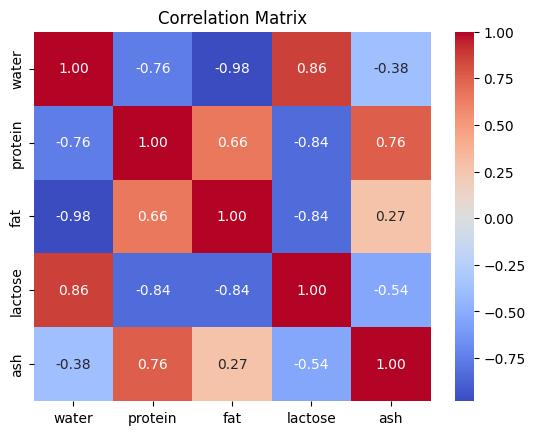

In [11]:
# Plot der Korrelationsmatrix
sns.heatmap(milk_perc_numeric_stand.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

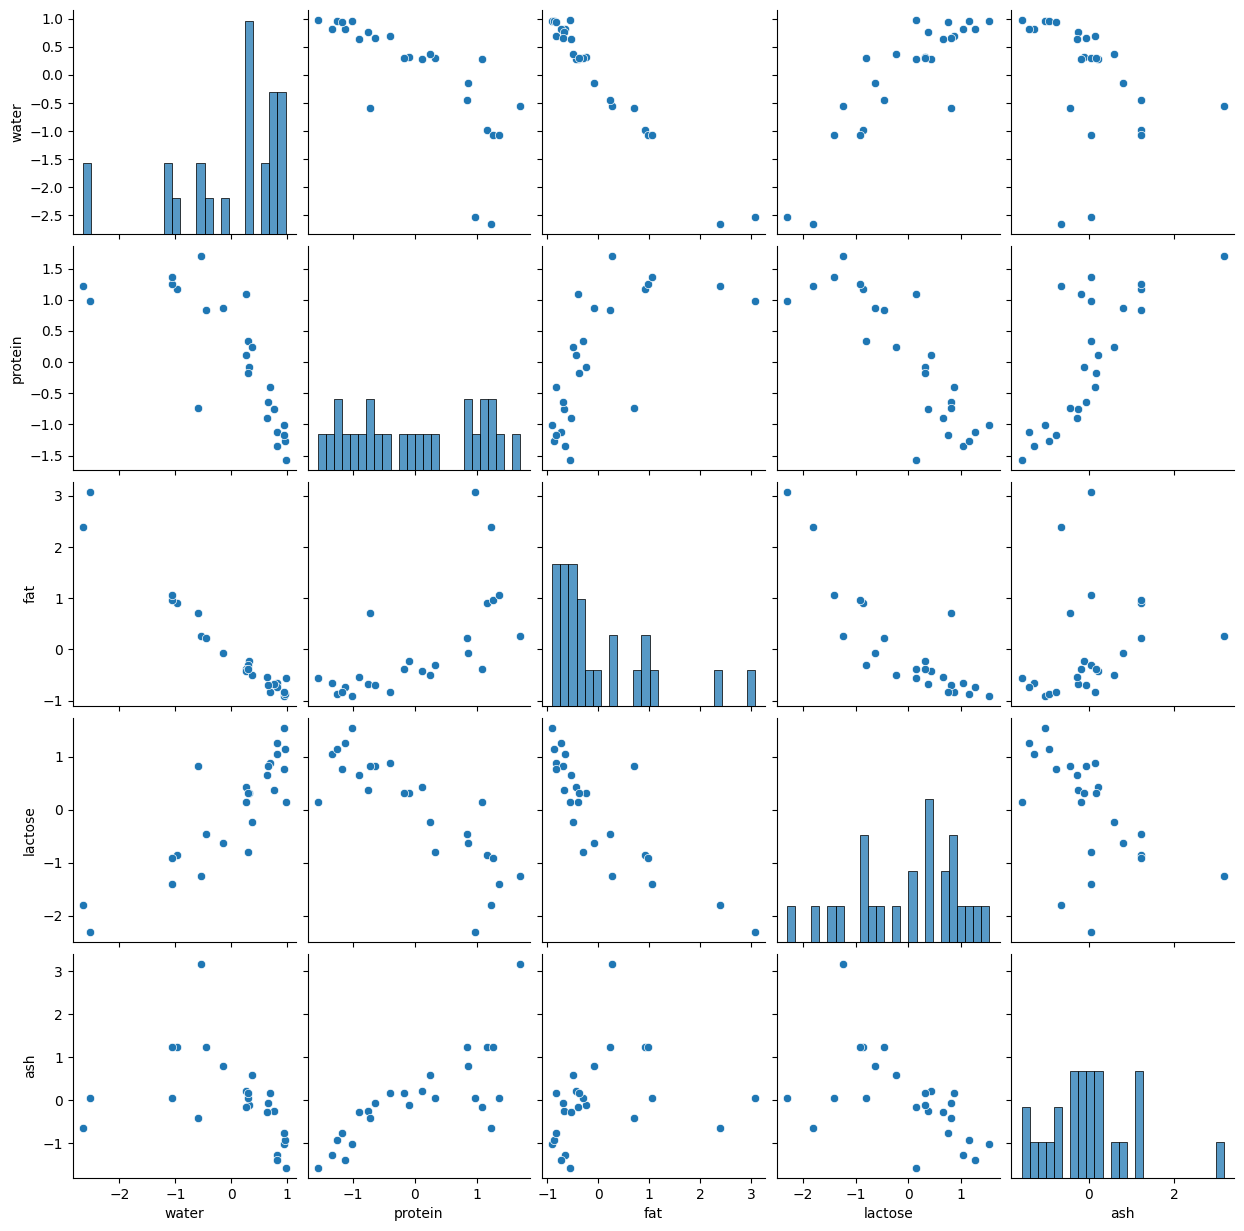

In [12]:
# Pairs plot
sns.pairplot(milk_perc_numeric_stand, diag_kind='hist', diag_kws={'bins':25})
plt.show()

#### 2 Partitionierende Verfahren: K-Means Clustering (Aufgabe 5.2)

In [13]:
# wir machen uns mit der KMeans Funktion vertraut
?KMeans

Init signature:
KMeans(
    n_clusters=8,
    *,
    init='k-means++',
    n_init='auto',
    max_iter=300,
    tol=0.0001,
    verbose=0,
    random_state=None,
    copy_x=True,
    algorithm='lloyd',
)
Docstring:     
K-Means clustering.

Read more in the :ref:`User Guide <k_means>`.

Parameters
----------

n_clusters : int, default=8
    The number of clusters to form as well as the number of
    centroids to generate.

    For an example of how to choose an optimal value for `n_clusters` refer to
    :ref:`sphx_glr_auto_examples_cluster_plot_kmeans_silhouette_analysis.py`.

init : {'k-means++', 'random'}, callable or array-like of shape             (n_clusters, n_features), default='k-means++'
    Method for initialization:

    * 'k-means++' : selects initial cluster centroids using sampling             based on an empirical probability distribution of the points'             contribution to the overall inertia. This technique speeds up             convergence. The algorithm imple

##### 2.1 2-Means Clustering

In [14]:
# 2-means clustering
kmeans_2 = KMeans(n_clusters=2, n_init=20, random_state=2).fit(milk_perc_numeric_stand)

In [15]:
# Ergebnisse des Clusterings: 
# Centroid-Vektoren (Cluster-Mittelpunkte)
# cluster_centers_ : ndarray of shape (n_clusters, n_features)
pd.DataFrame(kmeans_2.cluster_centers_,columns=milk_measures)

,water,protein,fat,lactose,ash
0,0.555367,-0.552345,-0.518490,0.565549,-0.417707
1,-1.180155,1.173734,1.101791,-1.201792,0.887628


In [16]:
# Clustering-Vektor -> Gruppenzuordnung der einzelnen Datenpunkte
# ndarray of shape (n_samples,)
pd.DataFrame({'Name': milk_perc_numeric_stand.index, 'Cluster':kmeans_2.labels_}).head()

,Name,Cluster
0,Horse,0
1,Orangutan,0
2,Monkey,0
3,Donkey,0
4,Hippo,0


In [17]:
# inertia: Sum of squared distances of samples to their closest cluster center = within cluster sum of squares (wss)
# repräsentiert Kompaktheit des Clusterings, je kleiner desto besser
kmeans_2.inertia_

51.864119739736836

##### 2.2 3-Means Clustering

In [18]:
kmeans_3 = KMeans(n_clusters=3, n_init=20, random_state=2).fit(milk_perc_numeric_stand)

In [19]:
# Ergebnisse des Clusterings: 
# Centroid-Vektoren (Cluster-Mittelpunkte)
pd.DataFrame(kmeans_3.cluster_centers_,columns=milk_measures)

,water,protein,fat,lactose,ash
0,0.607558,-0.789741,-0.544176,0.750255,-0.539898
1,-0.369423,0.983956,0.239656,-0.711183,0.906477
2,-2.590505,1.100384,2.730777,-2.051460,-0.299861


In [20]:
# Clustering-Vektor -> Gruppenzuordnung der einzelnen Datenpunkte
pd.DataFrame({'Name': milk_perc_numeric_stand.index, 'Cluster':kmeans_3.labels_}).head()

,Name,Cluster
0,Horse,0
1,Orangutan,0
2,Monkey,0
3,Donkey,0
4,Hippo,0


In [21]:
kmeans_3.inertia_

33.23330513296395

##### 2.3 4-Means Clustering

In [22]:
# Verwende 4 Cluster
kmeans_4 = KMeans(n_clusters=4, n_init=20, random_state=4).fit(milk_perc_numeric_stand)

In [23]:
# Ergebnisse des Clusterings: 
# Centroid-Vektoren (Cluster-Mittelpunkte)
pd.DataFrame(kmeans_4.cluster_centers_,columns=milk_measures)

,water,protein,fat,lactose,ash
0,0.910321,-1.246804,-0.759272,0.985057,-1.161531
1,-0.710039,1.198184,0.558796,-0.918570,1.283458
2,0.361756,-0.173550,-0.387155,0.336727,-0.011985
3,-2.590505,1.100384,2.730777,-2.051460,-0.299861


In [24]:
kmeans_4.inertia_

20.843667614290183

##### 2.4 5-Means Clustering

In [25]:
# Verwende 5 Cluster
kmeans_5 = KMeans(n_clusters=5, n_init=20, random_state=5).fit(milk_perc_numeric_stand)

In [26]:
kmeans_5.inertia_

16.019004302470577

#### 3 Hierarchische Clusteranalyse: Agglomeratives Clustering (Aufgabe 5.4)

In [28]:
# input y for die linkage Funktion: distance matrix oder Observationsmatrix
# "Alternatively, a collection of m observation vectors in n dimensions may be passed as an m by n array."
# wir haben 25 Observationen mit je 5 Dimensionen.
#?linkage

In [29]:
milk_perc_numeric_stand.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25 entries, Horse to Dolphin
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   water    25 non-null     float64
 1   protein  25 non-null     float64
 2   fat      25 non-null     float64
 3   lactose  25 non-null     float64
 4   ash      25 non-null     float64
dtypes: float64(5)
memory usage: 1.7+ KB


##### 3.1 Complete Linkage
Im Fall $\textit{Complete Linkage}$ betrachten wir als Abstandsmaß zwischen den Clustern
$$ d(\mathcal{C}_a,\mathcal{C}_b)= \max_{i\in\mathcal{C}_a,j\in\mathcal{C}_b} d(\mathbf{x}^{(i)}, \mathbf{x}^{(j)})\,.$$

In [30]:
# Hierarchisches Clustering mit Complete Linkage
linked_complete = linkage(milk_perc_numeric_stand, 'complete')

In [31]:
linked_complete

array([[20.        , 21.        ,  0.14557691,  2.        ],
       [10.        , 15.        ,  0.30938835,  2.        ],
       [ 1.        ,  2.        ,  0.34990626,  2.        ],
       [ 5.        , 14.        ,  0.36098597,  2.        ],
       [ 6.        , 11.        ,  0.36736033,  2.        ],
       [ 3.        , 12.        ,  0.42889571,  2.        ],
       [ 7.        , 26.        ,  0.44083479,  3.        ],
       [16.        , 19.        ,  0.62958368,  2.        ],
       [ 0.        , 27.        ,  0.70364026,  3.        ],
       [28.        , 29.        ,  0.76301402,  4.        ],
       [ 8.        , 13.        ,  0.80879083,  2.        ],
       [30.        , 33.        ,  0.8422925 ,  5.        ],
       [23.        , 24.        ,  1.13083844,  2.        ],
       [31.        , 34.        ,  1.20524224,  7.        ],
       [ 9.        , 35.        ,  1.23326155,  3.        ],
       [22.        , 25.        ,  1.33464795,  3.        ],
       [ 4.        , 36.

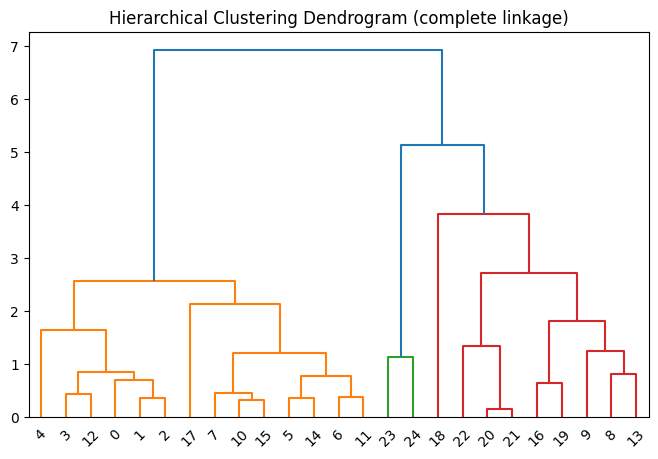

In [32]:
plt.figure(figsize=(8, 5))
dendrogram(linked_complete, orientation='top')
plt.title('Hierarchical Clustering Dendrogram (complete linkage)')
plt.show()

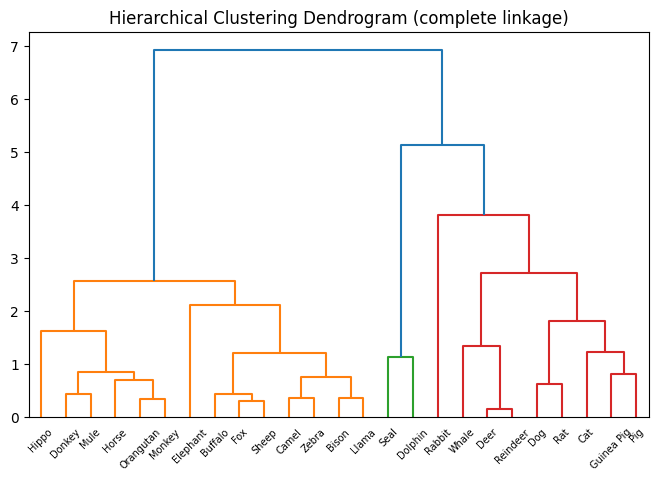

In [33]:
plt.figure(figsize=(8, 5))
dendrogram(linked_complete, labels=milk_perc_numeric_stand.index,leaf_font_size=7, orientation='top')
plt.title('Hierarchical Clustering Dendrogram (complete linkage)')
plt.show()

In [34]:
# die fcluster Funktion aus scipy.cluster.hierachy erlaubt es uns, das Dendrogramm bei einer spezifizierten Anzahl Cluster abzuschneiden 
# und die resultierenden Cluster Labels für jeden Datenpunkt zu erhalten
# Spezifiziere gewünschte Anzahl Cluster und speichere Labels
num_clusters_list=[2,3,4,5]
cluster_labels_dict={}

for num_clusters in num_clusters_list:
    labels= fcluster(linked_complete,num_clusters, criterion='maxclust')
    cluster_labels_dict[num_clusters]=labels

# Speichere Cluster-Labels in einem Dataframe
linkage_complete_cluster_labels_df=pd.DataFrame(cluster_labels_dict,index=milk_perc_numeric_stand.index)

In [36]:
linkage_complete_cluster_labels_df.tail()

,2,3,4,5
name,,,,
Deer,2,3,3,3
Reindeer,2,3,3,3
Whale,2,3,3,3
Seal,2,2,2,2
Dolphin,2,2,2,2


##### 3.2 Single Linkage
Im Fall $\textit{Single Linkage}$ betrachten wir als Abstandsmaß zwischen den Clustern
$$ d(\mathcal{C}_a,\mathcal{C}_b)= \min_{i\in\mathcal{C}_a,j\in\mathcal{C}_b} d(\mathbf{x}^{(i)}, \mathbf{x}^{(j)})\,.$$

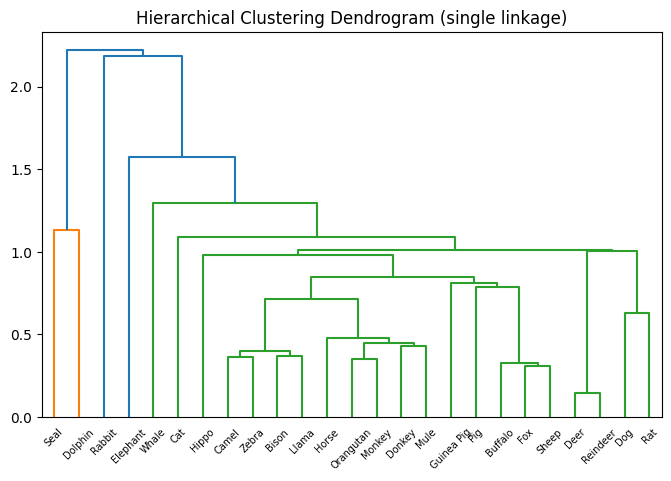

In [37]:
# Hierarchisches Clustering mit Single Linkage
linked_single = linkage(milk_perc_numeric_stand, 'single')

plt.figure(figsize=(8, 5))
dendrogram(linked_single, labels=milk_perc_numeric_stand.index, leaf_font_size=7, orientation='top')
plt.title('Hierarchical Clustering Dendrogram (single linkage)')
plt.show()

##### 3.3 Average Linkage
Im Fall $\textit{Average Linkage}$ betrachten wir als Abstandsmaß zwischen den Clustern
$$ d(\mathcal{C}_a,\mathcal{C}_b)= \frac{1}{|\mathcal{C}_a| |\mathcal{C}_b|}\sum_{i\in\mathcal{C}_a,j\in\mathcal{C}_b} d(\mathbf{x}^{(i)}, \mathbf{x}^{(j)})\,.$$

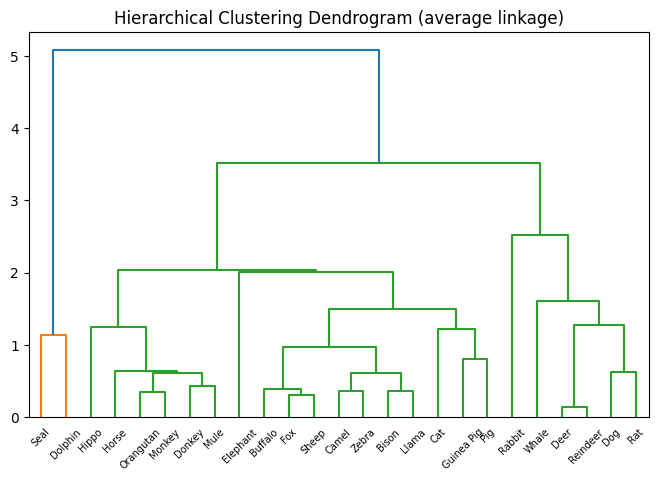

In [38]:
linked_average = linkage(milk_perc_numeric_stand, 'average')

plt.figure(figsize=(8, 5))
dendrogram(linked_average, labels=milk_perc_numeric_stand.index, leaf_font_size=7, orientation='top')
plt.title('Hierarchical Clustering Dendrogram (average linkage)')
plt.show()

##### 3.4 Centroid Linkage
Im Fall $\textit{Centroid Linkage}$ betrachten wir als Abstandsmaß zwischen den Clustern
$$ d(\mathcal{C}_a,\mathcal{C}_b)= d\left(\frac{1}{|\mathcal{C}_a|} \sum_{i\in\mathcal{C}_a}\mathbf{x}^{(i)}, \frac{1}{|\mathcal{C}_b|} \sum_{j\in\mathcal{C}_b}\mathbf{x}^{(j)}\right)\,.$$

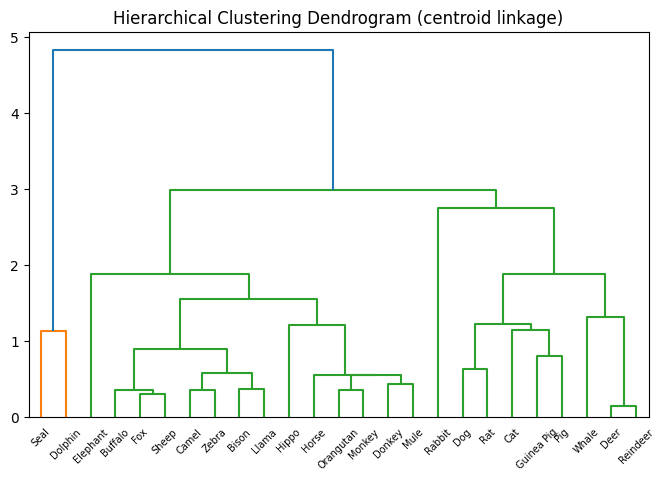

In [39]:
linked_centroid = linkage(milk_perc_numeric_stand, 'centroid')

plt.figure(figsize=(8, 5))
dendrogram(linked_centroid, labels=milk_perc_numeric_stand.index, leaf_font_size=7, orientation='top')
plt.title('Hierarchical Clustering Dendrogram (centroid linkage)')
plt.show()

#### 4. Visualisierung der Cluster (Aufgabe 5.5)

##### 4.1 Hauptkomponentenanalyse (PCA)
Wir führen eine Hauptkomponentenanalyse durch, um die Daten und ihre Cluster zu visualisieren.

In [40]:
pca = PCA(n_components=2) # 2-D visualization
milk_pca = pca.fit_transform(milk_perc_numeric_stand)
# Create a DataFrame for PCA results (i.e. score-vector of datapoints w.r.t principal components)
pca_df = pd.DataFrame(milk_pca, columns=['PC1', 'PC2'], index=milk_perc_numeric_stand.index)

In [41]:
#?PCA

In [42]:
# principal component vectors phi_1 and phi_2
pca.components_

array([[ 0.47886583, -0.46948001, -0.45420775,  0.4864534 , -0.32761935],
       [ 0.32895522,  0.30647266, -0.45258258,  0.06610027,  0.7672436 ]])

In [43]:
milk_perc_numeric_stand.iloc[0,:]

water      0.948806
protein   -1.009291
fat       -0.903208
lactose    1.542217
ash       -1.032281
Name: Horse, dtype: float64

In [44]:
pca.components_[0]

array([ 0.47886583, -0.46948001, -0.45420775,  0.4864534 , -0.32761935])

In [45]:
np.dot(milk_perc_numeric_stand.iloc[0,:],pca.components_[1])

np.float64(-0.27849900718651227)

In [46]:
# Score-Vektor der 25 Datenpunkte bzgl. PC1 und PC2
pca_df.head()

,PC1,PC2
name,,
Horse,2.426848,-0.278499
Orangutan,2.246782,-0.747914
Monkey,2.324038,-0.731326
Donkey,2.309902,-0.311041
Hippo,2.045255,-1.100888


##### 4.2 Visualisierung K-Means Clustering via PCA

In [47]:
# Add cluster labels
pca_df['Cluster_2means'] = kmeans_2.labels_
pca_df['Cluster_3means'] = kmeans_3.labels_
pca_df['Cluster_4means'] = kmeans_4.labels_
pca_df['Cluster_5means'] = kmeans_5.labels_

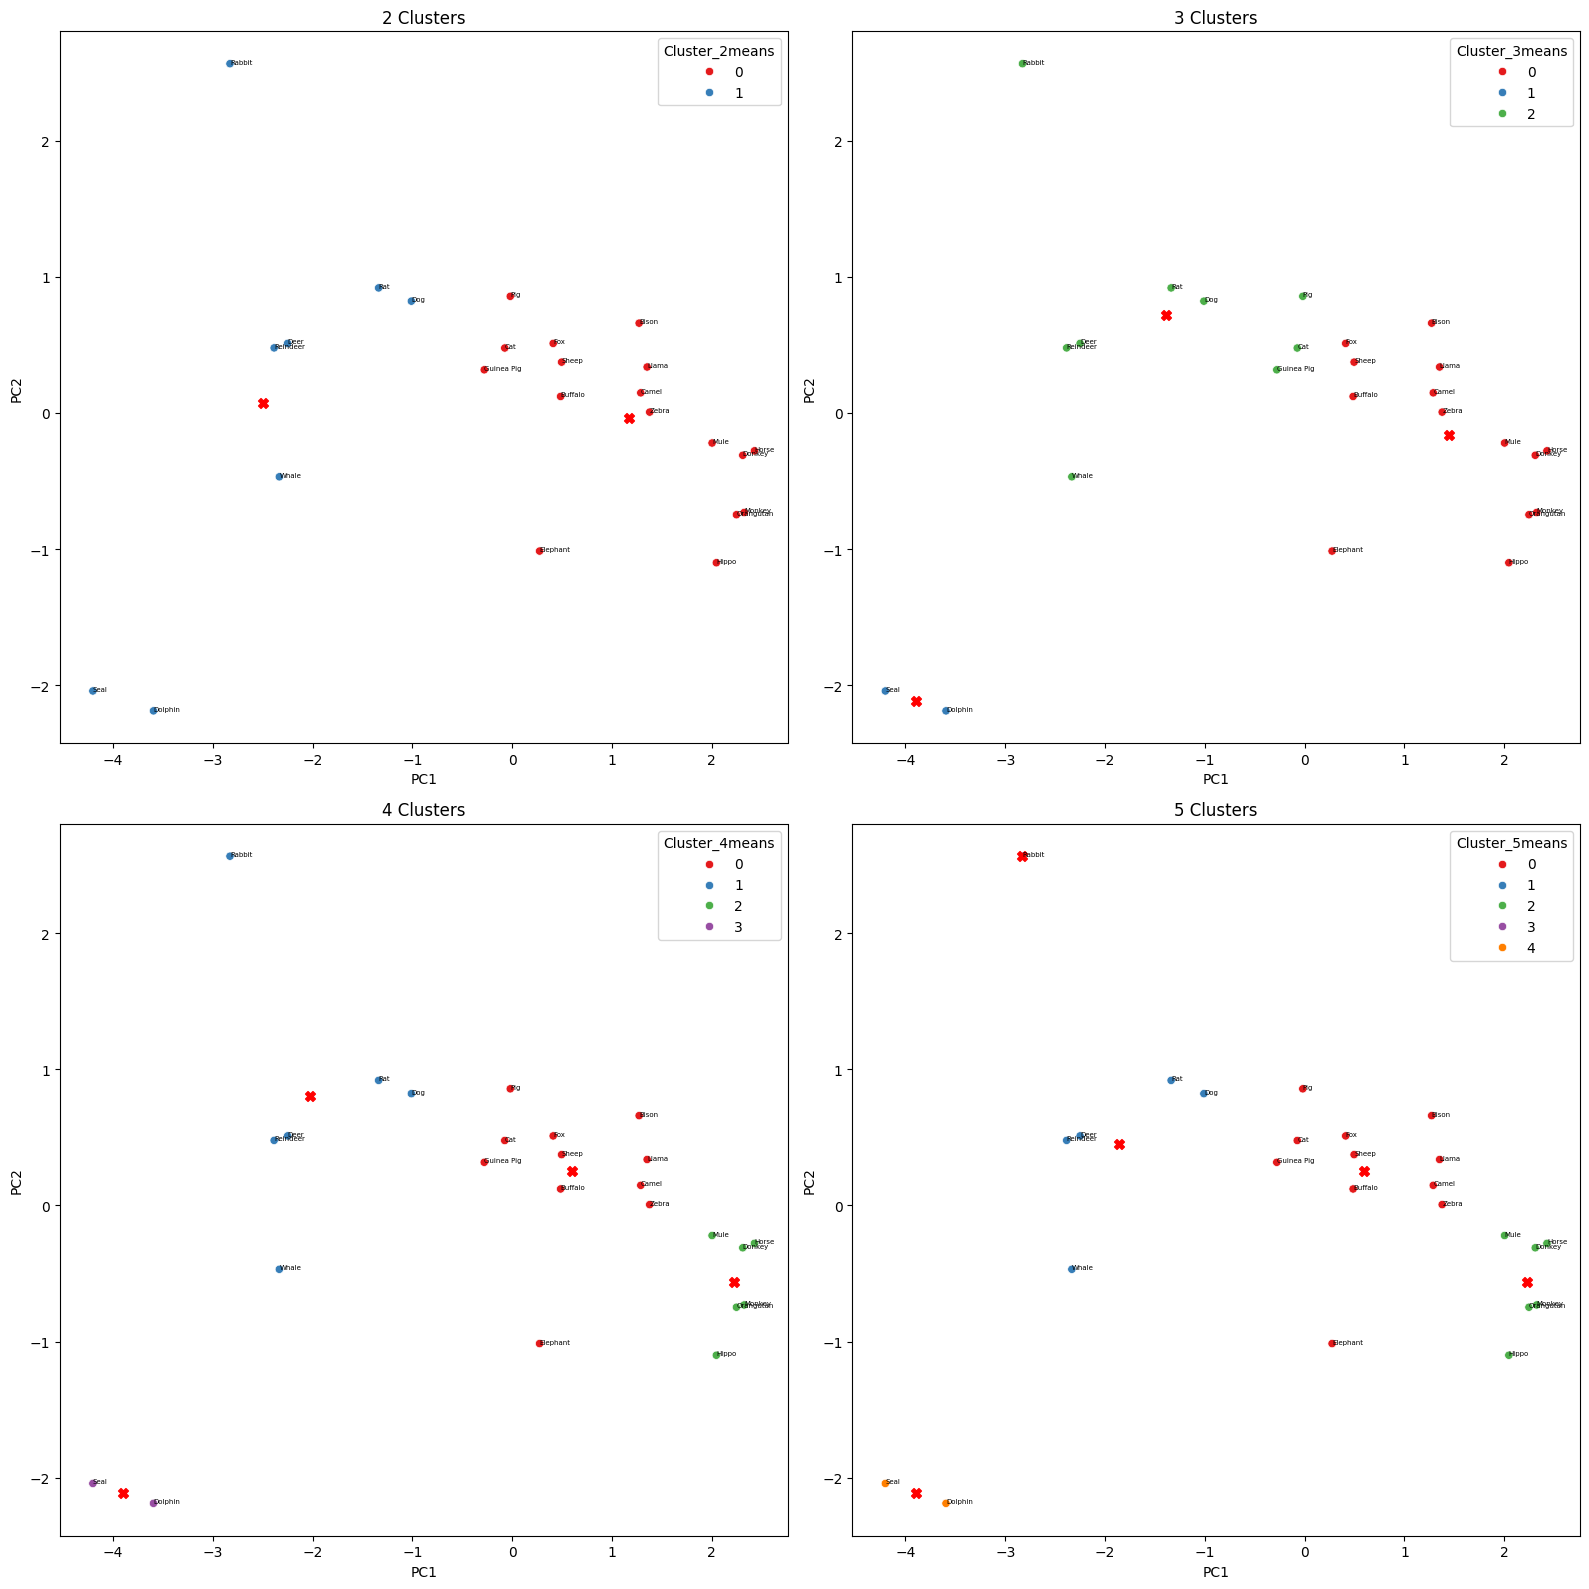

In [48]:
# Plot
fig, ax = plt.subplots(2, 2, figsize=(16, 16))

# Plot for 2 clusters
sns.scatterplot(x='PC1', y='PC2', hue='Cluster_2means', data=pca_df, ax=ax[0,0], palette='Set1')
ax[0,0].set_title('2 Clusters')

# Plot for 3 clusters
sns.scatterplot(x='PC1', y='PC2', hue='Cluster_3means', data=pca_df, ax=ax[0,1], palette='Set1')
ax[0,1].set_title('3 Clusters')

# Plot for 4 clusters
sns.scatterplot(x='PC1', y='PC2', hue='Cluster_4means', data=pca_df, ax=ax[1,0], palette='Set1')
ax[1,0].set_title('4 Clusters')

# Plot for 5 clusters
sns.scatterplot(x='PC1', y='PC2', hue='Cluster_5means', data=pca_df, ax=ax[1,1], palette='Set1')
ax[1,1].set_title('5 Clusters')

# Add names to each point
for i, name in enumerate(pca_df.index):
    ax[0,0].text(pca_df.iloc[i]['PC1'], pca_df.iloc[i]['PC2'], name, fontsize=5)
    ax[0,1].text(pca_df.iloc[i]['PC1'], pca_df.iloc[i]['PC2'], name, fontsize=5)
    ax[1,0].text(pca_df.iloc[i]['PC1'], pca_df.iloc[i]['PC2'], name, fontsize=5)
    ax[1,1].text(pca_df.iloc[i]['PC1'], pca_df.iloc[i]['PC2'], name, fontsize=5)


# Plot centroids
centroids_2 = pca.transform(pd.DataFrame(kmeans_2.cluster_centers_,columns=milk_measures))
centroids_3 = pca.transform(pd.DataFrame(kmeans_3.cluster_centers_,columns=milk_measures))
centroids_4 = pca.transform(pd.DataFrame(kmeans_4.cluster_centers_,columns=milk_measures))
centroids_5 = pca.transform(pd.DataFrame(kmeans_5.cluster_centers_,columns=milk_measures))

ax[0,0].scatter(centroids_2[:, 0], centroids_2[:, 1], s=50, c='red', marker='X')
ax[0,1].scatter(centroids_3[:, 0], centroids_3[:, 1], s=50, c='red', marker='X')
ax[1,0].scatter(centroids_4[:, 0], centroids_4[:, 1], s=50, c='red', marker='X')
ax[1,1].scatter(centroids_5[:, 0], centroids_5[:, 1], s=50, c='red', marker='X')

# Add arrows for principal components
#for i, (component, measure) in enumerate(zip(pca.components_.T, milk_measures)):
    #ax[0,0].arrow(0, 0, component[0], component[1], color='black', width=0.01, head_width=0.1)
    #ax[0,0].text(component[0] * 1.2, component[1] * 1.2, measure, color='black', fontsize=10)
    #ax[0,1].arrow(0, 0, component[0], component[1], color='black', width=0.01, head_width=0.1)
    #ax[0,1].text(component[0] * 1.2, component[1] * 1.2, measure, color='black', fontsize=10)

plt.tight_layout()
plt.show()


##### 4.3 Visualisierung Agglomeratives Clustering via PCA

In [49]:
# Add cluster labels
pca_df['Cluster_complete_linkage_2'] = linkage_complete_cluster_labels_df[2]
pca_df['Cluster_complete_linkage_3'] = linkage_complete_cluster_labels_df[3]
pca_df['Cluster_complete_linkage_4'] = linkage_complete_cluster_labels_df[4]
pca_df['Cluster_complete_linkage_5'] = linkage_complete_cluster_labels_df[5]

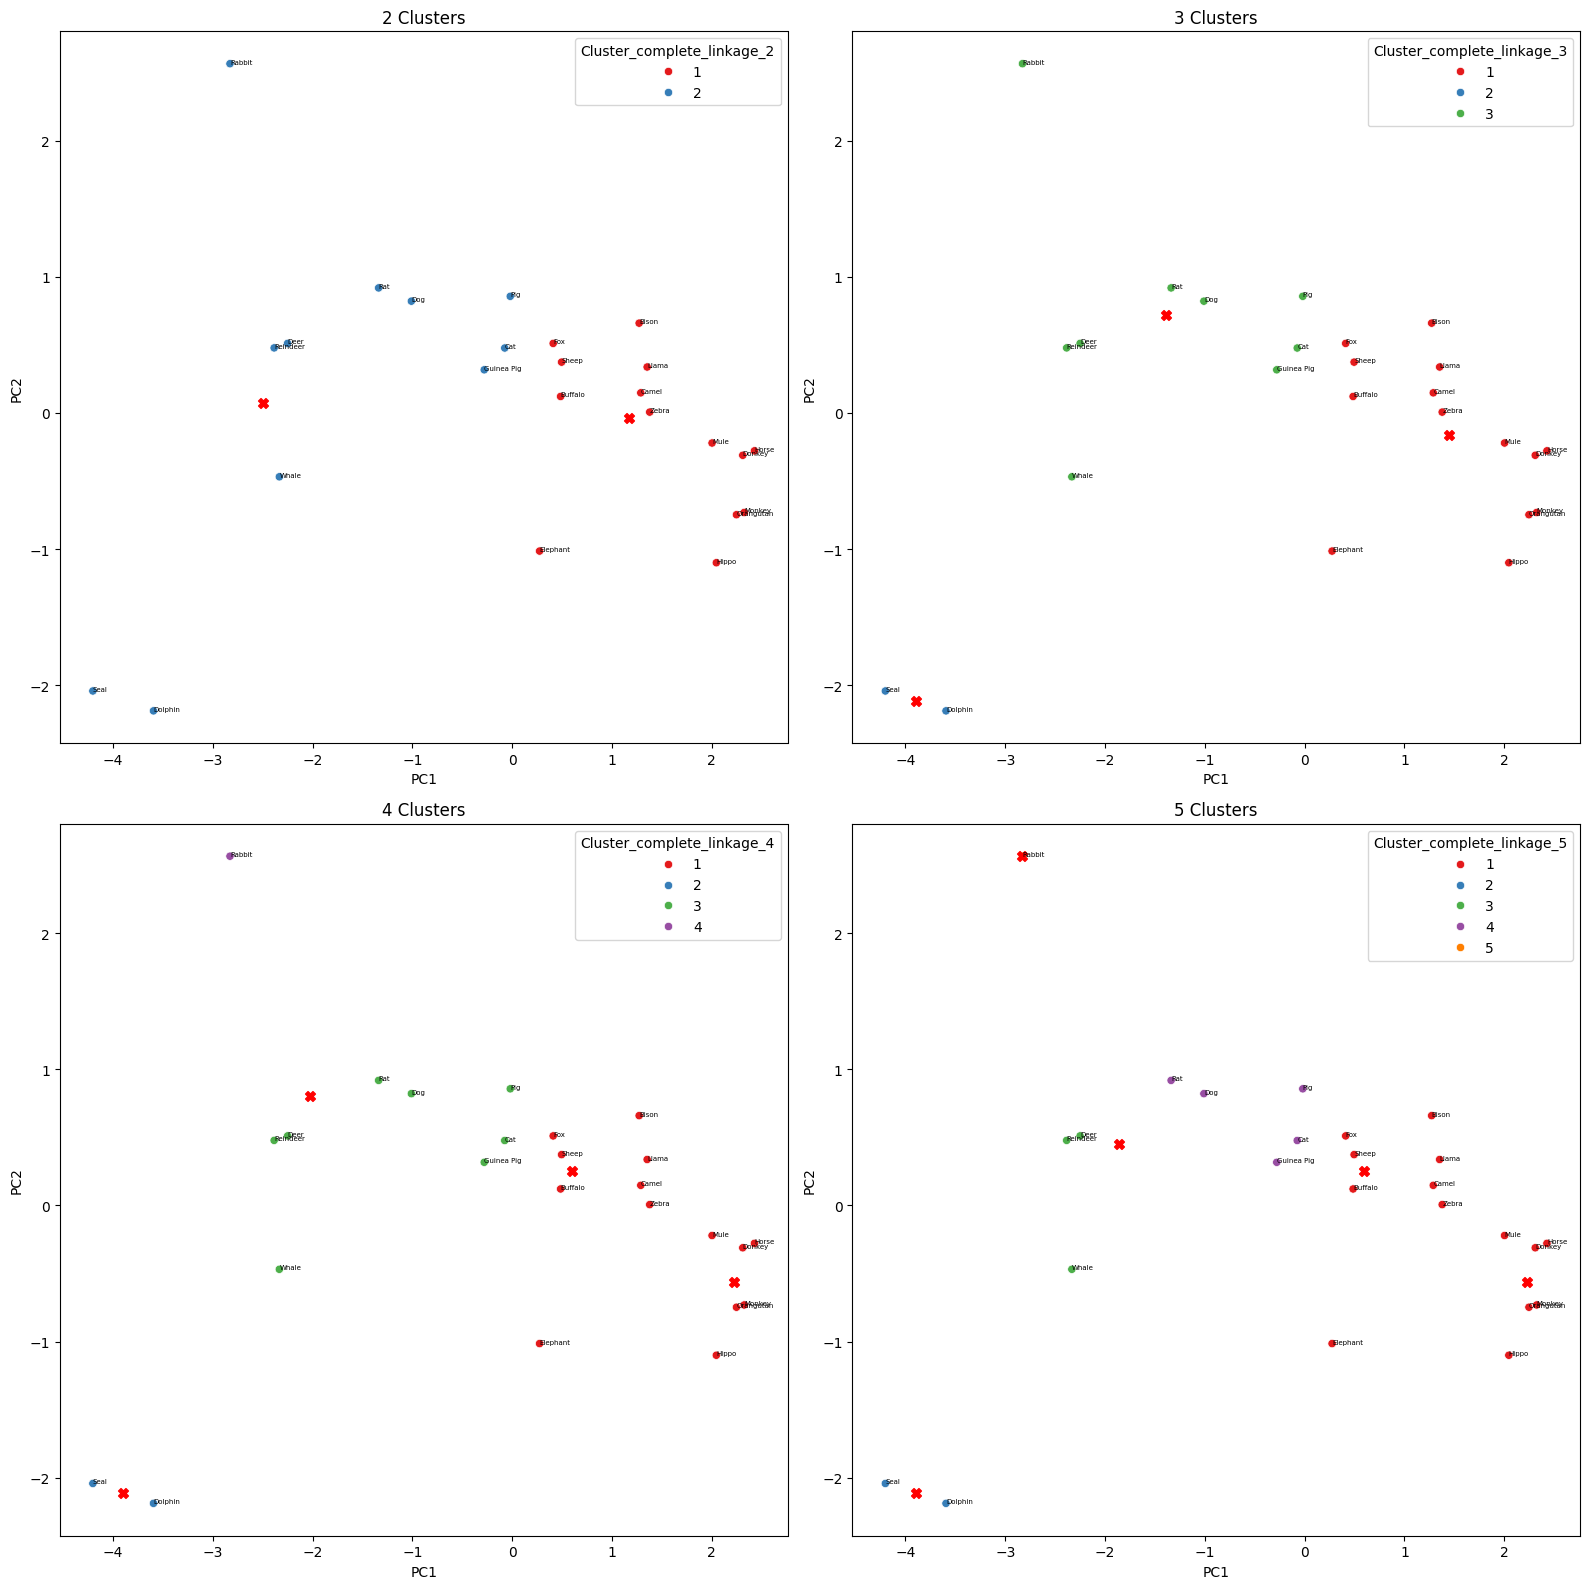

In [50]:
# Plot
fig, ax = plt.subplots(2, 2, figsize=(16, 16))

# Plot for 2 clusters
sns.scatterplot(x='PC1', y='PC2', hue='Cluster_complete_linkage_2', data=pca_df, ax=ax[0,0], palette='Set1')
ax[0,0].set_title('2 Clusters')

# Plot for 3 clusters
sns.scatterplot(x='PC1', y='PC2', hue='Cluster_complete_linkage_3', data=pca_df, ax=ax[0,1], palette='Set1')
ax[0,1].set_title('3 Clusters')

# Plot for 4 clusters
sns.scatterplot(x='PC1', y='PC2', hue='Cluster_complete_linkage_4', data=pca_df, ax=ax[1,0], palette='Set1')
ax[1,0].set_title('4 Clusters')

# Plot for 5 clusters
sns.scatterplot(x='PC1', y='PC2', hue='Cluster_complete_linkage_5', data=pca_df, ax=ax[1,1], palette='Set1')
ax[1,1].set_title('5 Clusters')

# Add names to each point
for i, name in enumerate(pca_df.index):
    ax[0,0].text(pca_df.iloc[i]['PC1'], pca_df.iloc[i]['PC2'], name, fontsize=5)
    ax[0,1].text(pca_df.iloc[i]['PC1'], pca_df.iloc[i]['PC2'], name, fontsize=5)
    ax[1,0].text(pca_df.iloc[i]['PC1'], pca_df.iloc[i]['PC2'], name, fontsize=5)
    ax[1,1].text(pca_df.iloc[i]['PC1'], pca_df.iloc[i]['PC2'], name, fontsize=5)


# Plot centroids
centroids_2 = pca.transform(pd.DataFrame(kmeans_2.cluster_centers_,columns=milk_measures))
centroids_3 = pca.transform(pd.DataFrame(kmeans_3.cluster_centers_,columns=milk_measures))
centroids_4 = pca.transform(pd.DataFrame(kmeans_4.cluster_centers_,columns=milk_measures))
centroids_5 = pca.transform(pd.DataFrame(kmeans_5.cluster_centers_,columns=milk_measures))

ax[0,0].scatter(centroids_2[:, 0], centroids_2[:, 1], s=50, c='red', marker='X')
ax[0,1].scatter(centroids_3[:, 0], centroids_3[:, 1], s=50, c='red', marker='X')
ax[1,0].scatter(centroids_4[:, 0], centroids_4[:, 1], s=50, c='red', marker='X')
ax[1,1].scatter(centroids_5[:, 0], centroids_5[:, 1], s=50, c='red', marker='X')

# Add arrows for principal components
#for i, (component, measure) in enumerate(zip(pca.components_.T, milk_measures)):
    #ax[0,0].arrow(0, 0, component[0], component[1], color='black', width=0.01, head_width=0.1)
    #ax[0,0].text(component[0] * 1.2, component[1] * 1.2, measure, color='black', fontsize=10)
    #ax[0,1].arrow(0, 0, component[0], component[1], color='black', width=0.01, head_width=0.1)
    #ax[0,1].text(component[0] * 1.2, component[1] * 1.2, measure, color='black', fontsize=10)

plt.tight_layout()
plt.show()


In [51]:
pca_df

,PC1,PC2,Cluster_2means,Cluster_3means,Cluster_4means,Cluster_5means,Cluster_complete_linkage_2,Cluster_complete_linkage_3,Cluster_complete_linkage_4,Cluster_complete_linkage_5
name,,,,,,,,,,
Horse,2.426848,-0.278499,0,0,2,2,1,1,1,1
Orangutan,2.246782,-0.747914,0,0,2,2,1,1,1,1
Monkey,2.324038,-0.731326,0,0,2,2,1,1,1,1
Donkey,2.309902,-0.311041,0,0,2,2,1,1,1,1
Hippo,2.045255,-1.100888,0,0,2,2,1,1,1,1
Camel,1.288255,0.147971,0,0,0,0,1,1,1,1
Bison,1.271973,0.660176,0,0,0,0,1,1,1,1
Buffalo,0.485045,0.121206,0,0,0,0,1,1,1,1
Guinea Pig,-0.279973,0.317202,0,2,0,0,2,3,3,4


#### 5 Cluster Evaluation (Aufgabe 5.5)

##### 5.1 Scree-Plot und Elbow-Kriterium am Beispiel K-Means
Das Elbow-Kriterium betrachtet den $\texttt{wss}$-Wert abhängig von der Anzahl der Cluster. Hierbei steht $\texttt{wss}$ für $\textit{within cluster sum of squares}$, ein Maß für die Heterogenität der Cluster ($\textit{variance within}$):
$$ \mathrm{inertia} = wss = \sum_{\mathcal{C}_\alpha} \sum_{\mathbf{x}^{(i)}\in\mathcal{C}_\alpha}  d\left(\mathbf{x}^{(i)},\frac{1}{\vert\mathcal{C}_\alpha\vert}\sum_{\mathbf{x}^{(j)}\in \mathcal{C}_\alpha} \mathbf{x}^j\right) $$

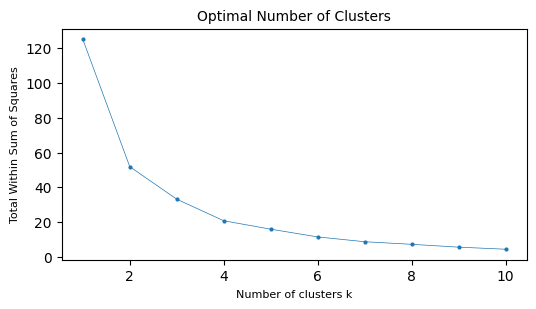

In [62]:
# Optimal number of clusters using the elbow method
# WSS = Within cluster sum of squares
wss = []
for i in range(1, 11):
    km = KMeans(n_clusters=i, n_init=20).fit(milk_perc_numeric_stand)
    wss.append(km.inertia_)

plt.figure(figsize=(6, 3))
plt.plot(range(1, 11), wss, linewidth=0.5, marker='o', markersize=2)
plt.title('Optimal Number of Clusters', fontsize=10, fontweight='normal')
plt.xlabel('Number of clusters k', fontsize=8, fontweight='light')
plt.ylabel('Total Within Sum of Squares', fontsize =8, fontweight='light')
#plt.savefig('05_ElbowKriterium_KMeans.png', format='png',dpi=300, bbox_inches='tight')
plt.show()

##### 5.2 Silhouette Plot am Beispiel K-Means
Der Silhouettenkoeffizient ist eine Metrik zur Beurteilung der Cluster-Qualität. Hierbei erweitert man das Maß für die $\textit{variance within}$ (Varianz innerhalb der Cluster) um ein Maß für die $\textit{variance between}$ (Varianz zwischen den Clustern bzw. Verschiedenheit der Cluster). 

Der Silhouette-Wert(zwischen -1 und 1) errechnet sich für jeden Datenpunkt aus der durchschnittlichen Distanz zwischen dem Punkt
- und allen anderen Punkten im selben Cluster -> je kleiner desto besser.
- und allen Punkten im nähesten Cluster (zu dem der Punkt nicht gehört) -> je größer desto besser.
  
Der Silhouettenkoeffizient errechnet sich als durchschnittlicher Silhouette-Wert aller Punkte. 

In [51]:
# Silhouette analysis
for n_clusters in range(1,11):
    clusterer = KMeans(n_clusters=n_clusters, n_init=20)
    cluster_labels = clusterer.fit_predict(milk_perc_numeric_stand)
    silhouette_avg = silhouette_score(milk_perc_numeric_stand, cluster_labels)
    print(f"For n_clusters = {n_clusters}, the average silhouette_score is : {silhouette_avg}")

For n_clusters = 2, the average silhouette_score is : 0.5122014747676669
For n_clusters = 3, the average silhouette_score is : 0.4685842603383366
For n_clusters = 4, the average silhouette_score is : 0.4249872305210203
For n_clusters = 5, the average silhouette_score is : 0.4076984922264063


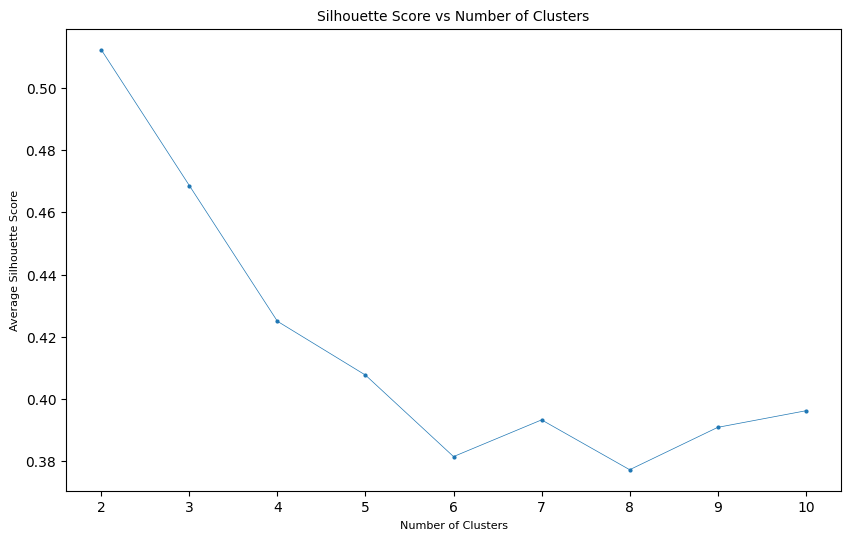

In [65]:
silhouette_scores = []

# Perform silhouette analysis for different numbers of clusters
for n_clusters in range(1, 11):
    clusterer = KMeans(n_clusters=n_clusters, n_init=20)
    cluster_labels = clusterer.fit_predict(milk_perc_numeric_stand)
    
    # Calculate silhouette scores
    if n_clusters > 1:
        silhouette_avg = silhouette_score(milk_perc_numeric_stand, cluster_labels)
        silhouette_scores.append(silhouette_avg)
    else:
        silhouette_scores.append(np.nan)  # Silhouette score is not defined for n_clusters=1

# Plot average silhouette scores for clusters from 1 to 10
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), silhouette_scores, linewidth=0.5, marker='o', markersize=2)
plt.title('Silhouette Score vs Number of Clusters',fontsize=10, fontweight='normal')
plt.xlabel('Number of Clusters', fontsize=8, fontweight='light')
plt.ylabel('Average Silhouette Score', fontsize=8, fontweight='light')
#plt.grid(True)
plt.show()

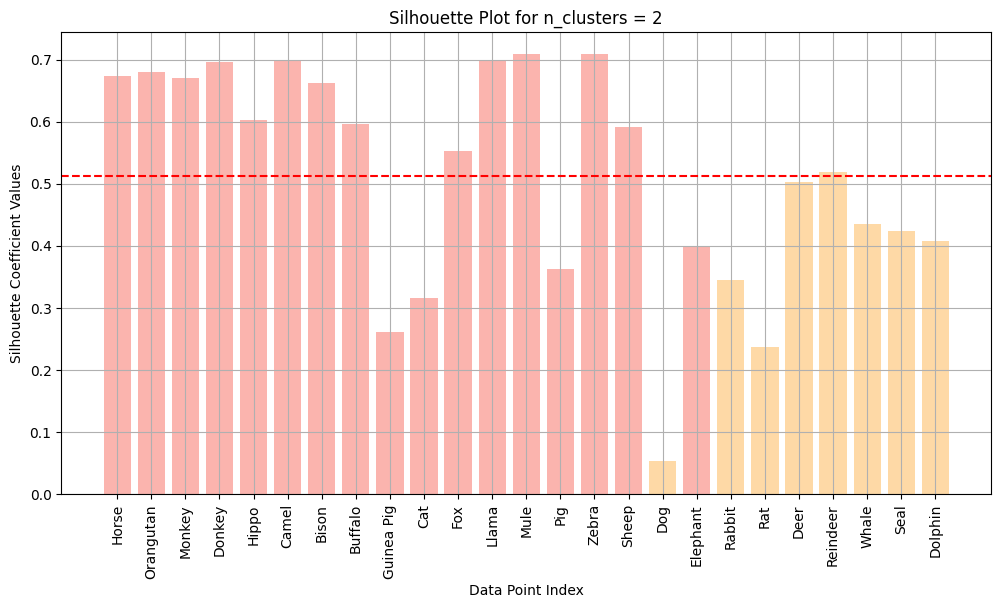

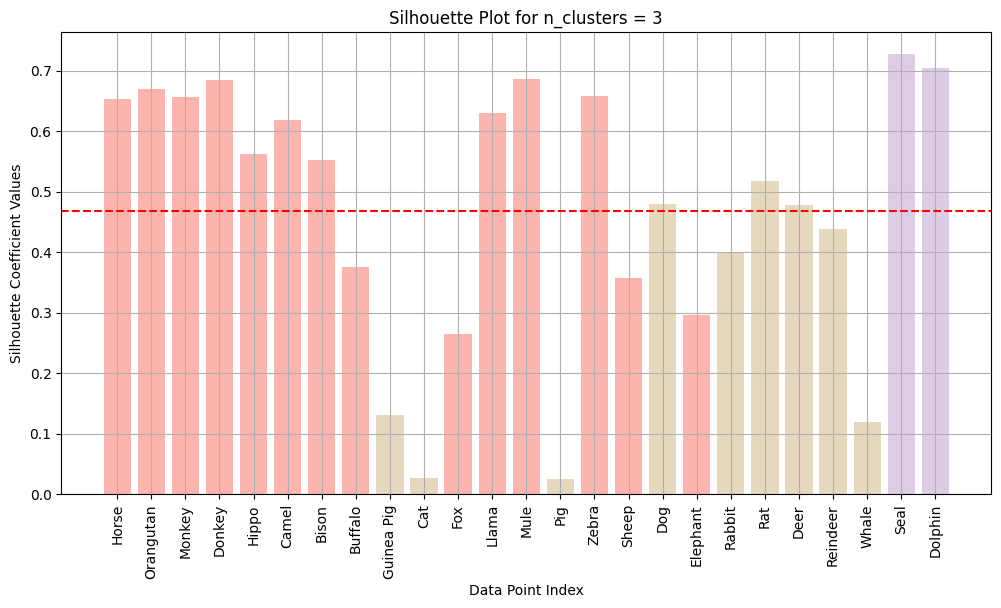

In [73]:
for n_clusters in [2, 3]:
    clusterer = KMeans(n_clusters=n_clusters, n_init=20, random_state=42)
    cluster_labels = clusterer.fit_predict(milk_perc_numeric_stand)
    silhouette_values = silhouette_samples(milk_perc_numeric_stand, cluster_labels)
    
    plt.figure(figsize=(12, 6))
    
    # Plot silhouette scores as bars with colors based on cluster labels
    colors = plt.cm.Pastel1(cluster_labels.astype(float) / n_clusters)
    plt.bar(range(len(silhouette_values)), silhouette_values,color=colors)
    
    # Add index of the data points to the x-axis
    plt.xticks(range(len(silhouette_values)), milk_perc_numeric_stand.index, rotation=90)
    
    silhouette_avg = np.mean(silhouette_values)  # Calculate the average silhouette score
    
    plt.title(f'Silhouette Plot for n_clusters = {n_clusters}')
    plt.ylabel('Silhouette Coefficient Values')
    plt.xlabel('Data Point Index')
    plt.axhline(y=silhouette_avg, color="red", linestyle="--")
    plt.grid(True)
    plt.show()
